# Backtesting Fibonacci Strategies

## Getting the Data

In [1]:
import sys
sys.path.append('../../')

In [2]:
from config.constants import *
from backtesting import Backtest, Strategy
from backtesting.test import EURUSD, SMA
from backtesting.lib import plot_heatmaps, resample_apply
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util.ATR import *
from util.SMA import *
from util.plot_return import *
from util.Bollinger_bands import *
from util.load_data import *

In [3]:
XAUUSD = load_data()

In [4]:
XAUUSD['H4']

,Open,High,Low,Close,Volume
Time,,,,,
2007-01-01 00:00:00,635.679,636.194,635.009,635.497,95
2007-01-01 04:00:00,635.336,636.220,635.254,635.699,97
2007-01-01 08:00:00,635.780,636.225,635.201,635.993,99
2007-01-01 12:00:00,636.053,636.189,635.117,636.006,90
2007-01-01 16:00:00,635.902,636.185,635.006,635.989,96
...,...,...,...,...,...
2023-03-10 00:00:00,1831.428,1834.765,1827.974,1829.085,240
2023-03-10 04:00:00,1829.085,1834.575,1827.675,1833.405,240
2023-03-10 08:00:00,1833.415,1837.245,1830.778,1834.865,240


In [5]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


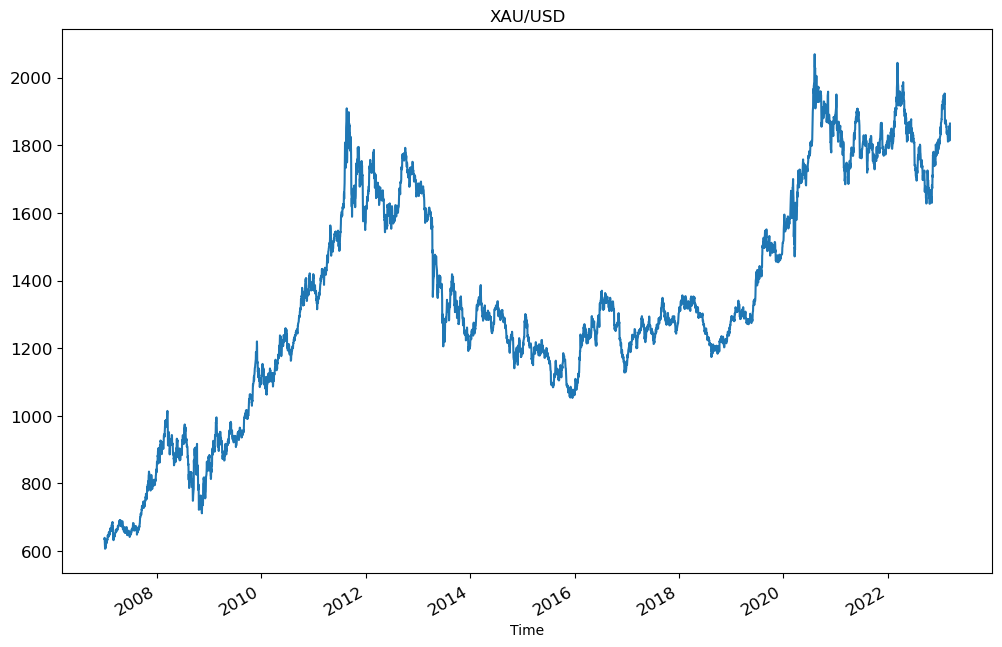

In [6]:
XAUUSD['D1'].Close.plot(figsize=(12, 8), title="XAU/USD", fontsize=12)
plt.show()

# Prepare data

## High and Lows - an iterative approach

In [11]:
from scipy.signal import argrelextrema

In [9]:
data = XAUUSD['D1'].copy()

In [12]:
ll = data.Low.copy()

In [10]:
order = 70  # approx. 3 month

In [13]:
local_min = argrelextrema(ll.values, np.less_equal, order=order)

In [14]:
local_min

(array([   4,  151,  417,  568,  720,  970, 1118, 1276, 1562, 1679, 2028,
        2186, 2317, 2451, 2562, 2668, 2785, 2935, 3106, 3280, 3413, 3622,
        3843, 4009, 4116, 4419, 4549, 4904], dtype=int64),)

In [17]:
data

,Open,High,Low,Close,Volume,hh,hh_date
Time,,,,,,,
2007-01-01,635.679,637.103,635.006,635.943,604,NaN,NaN
2007-01-02,635.791,640.802,635.286,639.143,1282,NaN,NaN
2007-01-03,639.029,644.663,624.634,626.602,1302,NaN,NaN
2007-01-04,626.699,630.352,619.600,622.533,1365,NaN,NaN
2007-01-05,622.268,625.768,601.591,606.841,1284,NaN,NaN
...,...,...,...,...,...,...,...
2023-03-06,1852.255,1858.168,1845.015,1846.255,1380,NaN,NaN
2023-03-07,1846.225,1851.555,1812.655,1813.865,1380,NaN,NaN
2023-03-08,1813.855,1824.185,1809.248,1815.175,1379,NaN,NaN


In [16]:
data["hh"] = np.nan
data["hh_date"] = np.nan

In [18]:
for bar in range(len(data)):  # iterating over the bars
    date = data.index[bar]  # determine the current bar´s date
    hh = data.iloc[:bar+1].High  # get the high column until current bar

    # determine all local highs until current bar
    local_max = argrelextrema(hh.values, np.greater_equal, order=order)

    # determine the most recent local high (price) and add to "hh" column
    data.loc[date, "hh"] = data.High.values[local_max][-1]

    # determine the most recent local high (date) and add to "hh_date" column
    data.loc[date, "hh_date"] = data.index[local_max][-1]

In [19]:
data["ll"] = np.nan
data["ll_date"] = np.nan

In [20]:
for bar in range(len(data)):  # iterating over the bars
    date = data.index[bar]  # determine the current bar´s date
    ll = data.iloc[:bar+1].Low  # get the high column until current bar

    # determine all local lows until current bar
    local_min = argrelextrema(ll.values, np.less_equal, order=order)

    # determine the most recent local low (price) and add to "ll" column
    data.loc[date, "ll"] = data.Low.values[local_min][-1]

    # determine the most recent local low (date) and add to "ll_date" column
    data.loc[date, "ll_date"] = data.index[local_min][-1]

In [21]:
data["Trend"] = np.where(data.hh_date > data.ll_date, 1, -1)

In [24]:
data

,Open,High,Low,Close,Volume,hh,hh_date,ll,ll_date,Trend
Time,,,,,,,,,,
2007-01-01,635.679,637.103,635.006,635.943,604,637.103,2007-01-01 00:00:00,635.006,2007-01-01 00:00:00,Down
2007-01-02,635.791,640.802,635.286,639.143,1282,640.802,2007-01-02 00:00:00,635.006,2007-01-01 00:00:00,Up
2007-01-03,639.029,644.663,624.634,626.602,1302,644.663,2007-01-03 00:00:00,624.634,2007-01-03 00:00:00,Down
2007-01-04,626.699,630.352,619.600,622.533,1365,644.663,2007-01-03 00:00:00,619.600,2007-01-04 00:00:00,Down
2007-01-05,622.268,625.768,601.591,606.841,1284,644.663,2007-01-03 00:00:00,601.591,2007-01-05 00:00:00,Down
...,...,...,...,...,...,...,...,...,...,...
2023-03-06,1852.255,1858.168,1845.015,1846.255,1380,1959.625,2023-02-02 00:00:00,1614.710,2022-09-28 00:00:00,Up
2023-03-07,1846.225,1851.555,1812.655,1813.865,1380,1959.625,2023-02-02 00:00:00,1614.710,2022-09-28 00:00:00,Up
2023-03-08,1813.855,1824.185,1809.248,1815.175,1379,1959.625,2023-02-02 00:00:00,1614.710,2022-09-28 00:00:00,Up


In [23]:
data["Trend"] = np.where(data.hh_date > data.ll_date, "Up", "Down")

In [25]:
data.drop(columns=["hh_date", "ll_date"], inplace=True)

## Adding Fibonacci Retracement Levels

__Fibonacci Levels derived from Fibonacci numbers: 23.6%, 38.2%, (61.8%)__

In [26]:
data["R23.6"] = np.where(data.Trend == "Up", data.hh - (data.hh-data.ll)
                         * 0.236, data.hh - (data.hh-data.ll) * (1-0.236))

In [27]:
data["R38.2"] = np.where(data.Trend == "Up", data.hh - (data.hh-data.ll)
                         * 0.382, data.hh - (data.hh-data.ll) * (1-0.382))

In [28]:
data["position"] = np.where((data.hh != data.hh.shift()) | (
    data.ll != data.ll.shift()), 0, np.nan)

In [29]:
data["position"] = np.where((data.Trend == "Down") & (data.Close.shift(
) < data["R23.6"].shift()) & (data.Close > data["R23.6"]), 1, data.position)

In [30]:
data["position"] = np.where((data.Trend == "Down") & (data.Close.shift(
) < data["R38.2"].shift()) & (data.Close >= data["R38.2"]), 0, data.position)

In [31]:
data["position"] = np.where((data.Trend == "Down") & (
    data.Close.shift() > data.ll.shift()) & (data.Close <= data.ll), 0, data.position)

In [32]:
data["position"] = np.where((data.Trend == "Up") & (data.Close.shift(
) > data["R23.6"].shift()) & (data.Close < data["R23.6"]), -1, data.position)


In [33]:
data["position"] = np.where((data.Trend == "Up") & (data.Close.shift(
) > data["R38.2"].shift()) & (data.Close <= data["R38.2"]), 0, data.position)


In [34]:
data["position"] = np.where((data.Trend == "Up") & (data.Close.shift(
) < data.hh.shift()) & (data.Close >= data.hh), 0, data.position)

In [35]:
data["position"] = np.where((data.hh != data.hh.shift()) | (
    data.ll != data.ll.shift()), 0, data.position)

In [36]:
data["position"] = data.position.ffill()

## Vectorized Strategy Backtesting

In [37]:
data["returns"] = np.log(data.Close.div(data.Close.shift(1)))

In [38]:
data["strategy"] = data.position.shift(1) * data["returns"]

In [39]:
data.dropna(inplace=True)

In [42]:
data["creturns"] = data["returns"].cumsum().apply(np.exp)
data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)

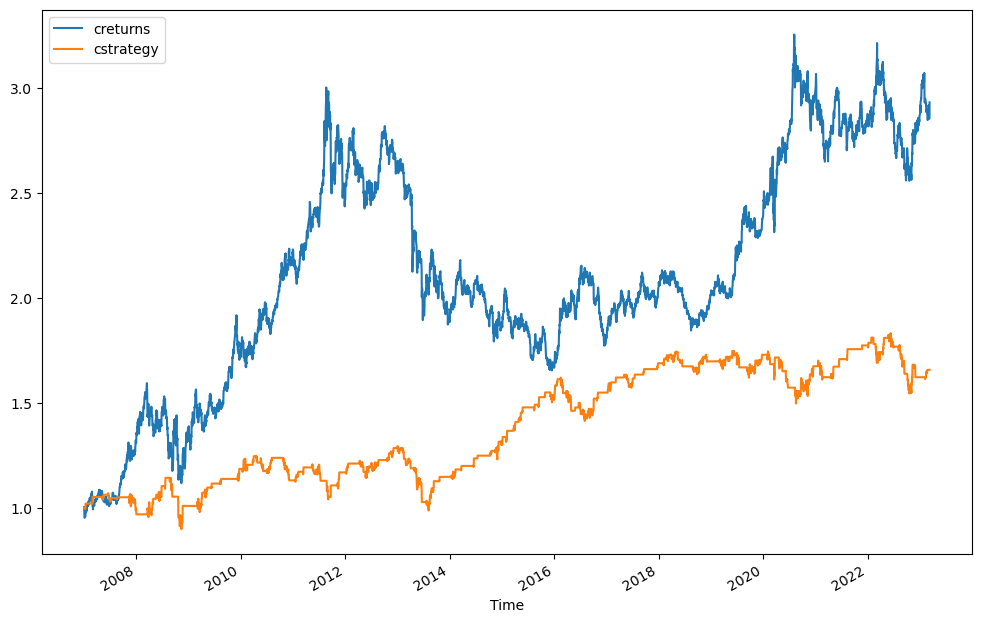

In [43]:
data[["creturns", "cstrategy"]].plot(figsize=(12, 8))
plt.show()

# Definde strategy

In [47]:
data

,Open,High,Low,Close,Volume,hh,ll,Trend,R23.6,R38.2,position,returns,strategy,creturns,cstrategy
Time,,,,,,,,,,,,,,,
2007-01-02,635.791,640.802,635.286,639.143,1282,640.802,635.006,Up,639.434144,638.587928,0.0,0.005019,0.0,1.005032,1.000000
2007-01-03,639.029,644.663,624.634,626.602,1302,644.663,624.634,Down,629.360844,632.285078,0.0,-0.019817,-0.0,0.985312,1.000000
2007-01-04,626.699,630.352,619.600,622.533,1365,644.663,619.600,Down,625.514868,629.174066,0.0,-0.006515,-0.0,0.978913,1.000000
2007-01-05,622.268,625.768,601.591,606.841,1284,644.663,601.591,Down,611.755992,618.044504,0.0,-0.025530,-0.0,0.954238,1.000000
2007-01-07,606.711,608.966,606.274,607.867,72,644.663,601.591,Down,611.755992,618.044504,0.0,0.001689,0.0,0.955851,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-06,1852.255,1858.168,1845.015,1846.255,1380,1959.625,1614.710,Up,1878.225060,1827.867470,0.0,-0.003245,-0.0,2.903177,1.658444
2023-03-07,1846.225,1851.555,1812.655,1813.865,1380,1959.625,1614.710,Up,1878.225060,1827.867470,0.0,-0.017699,-0.0,2.852245,1.658444
2023-03-08,1813.855,1824.185,1809.248,1815.175,1379,1959.625,1614.710,Up,1878.225060,1827.867470,0.0,0.000722,0.0,2.854305,1.658444


In [50]:
class Fibonacci(Strategy):
  

    def init(self):
        return
    def next(self):

        # position = self.data.df.loc[self.data.df.index[-1], 'position']
        
        if self.data.position == 1  :
            if self.position.is_short :
                self.position.close()
            self.buy(size=1)
         
        if self.data.position == -1:
            if self.position.is_long:
                self.position.close()
            self.sell(size=1)
      

## Backtesting

In [44]:
account_size = 20000

In [51]:
bt = Backtest(data, Fibonacci, cash=account_size, margin=1/2000 )
result = bt.run()
result

Start                     2007-01-02 00:00:00
End                       2023-03-10 00:00:00
Duration                   5911 days 00:00:00
Exposure Time [%]                   99.861166
Equity Final [$]                    47302.698
Equity Peak [$]                      52024.81
Return [%]                          136.51349
Buy & Hold Return [%]              191.655858
Return (Ann.) [%]                    4.396366
Volatility (Ann.) [%]               64.107548
Sharpe Ratio                         0.068578
Sortino Ratio                        0.133286
Calmar Ratio                         0.048863
Max. Drawdown [%]                  -89.973126
Avg. Drawdown [%]                   -6.840325
Max. Drawdown Duration     2973 days 00:00:00
Avg. Drawdown Duration      111 days 00:00:00
# Trades                                 1776
Win Rate [%]                        70.664414
Best Trade [%]                      30.155524
Worst Trade [%]                    -18.964199
Avg. Trade [%]                    

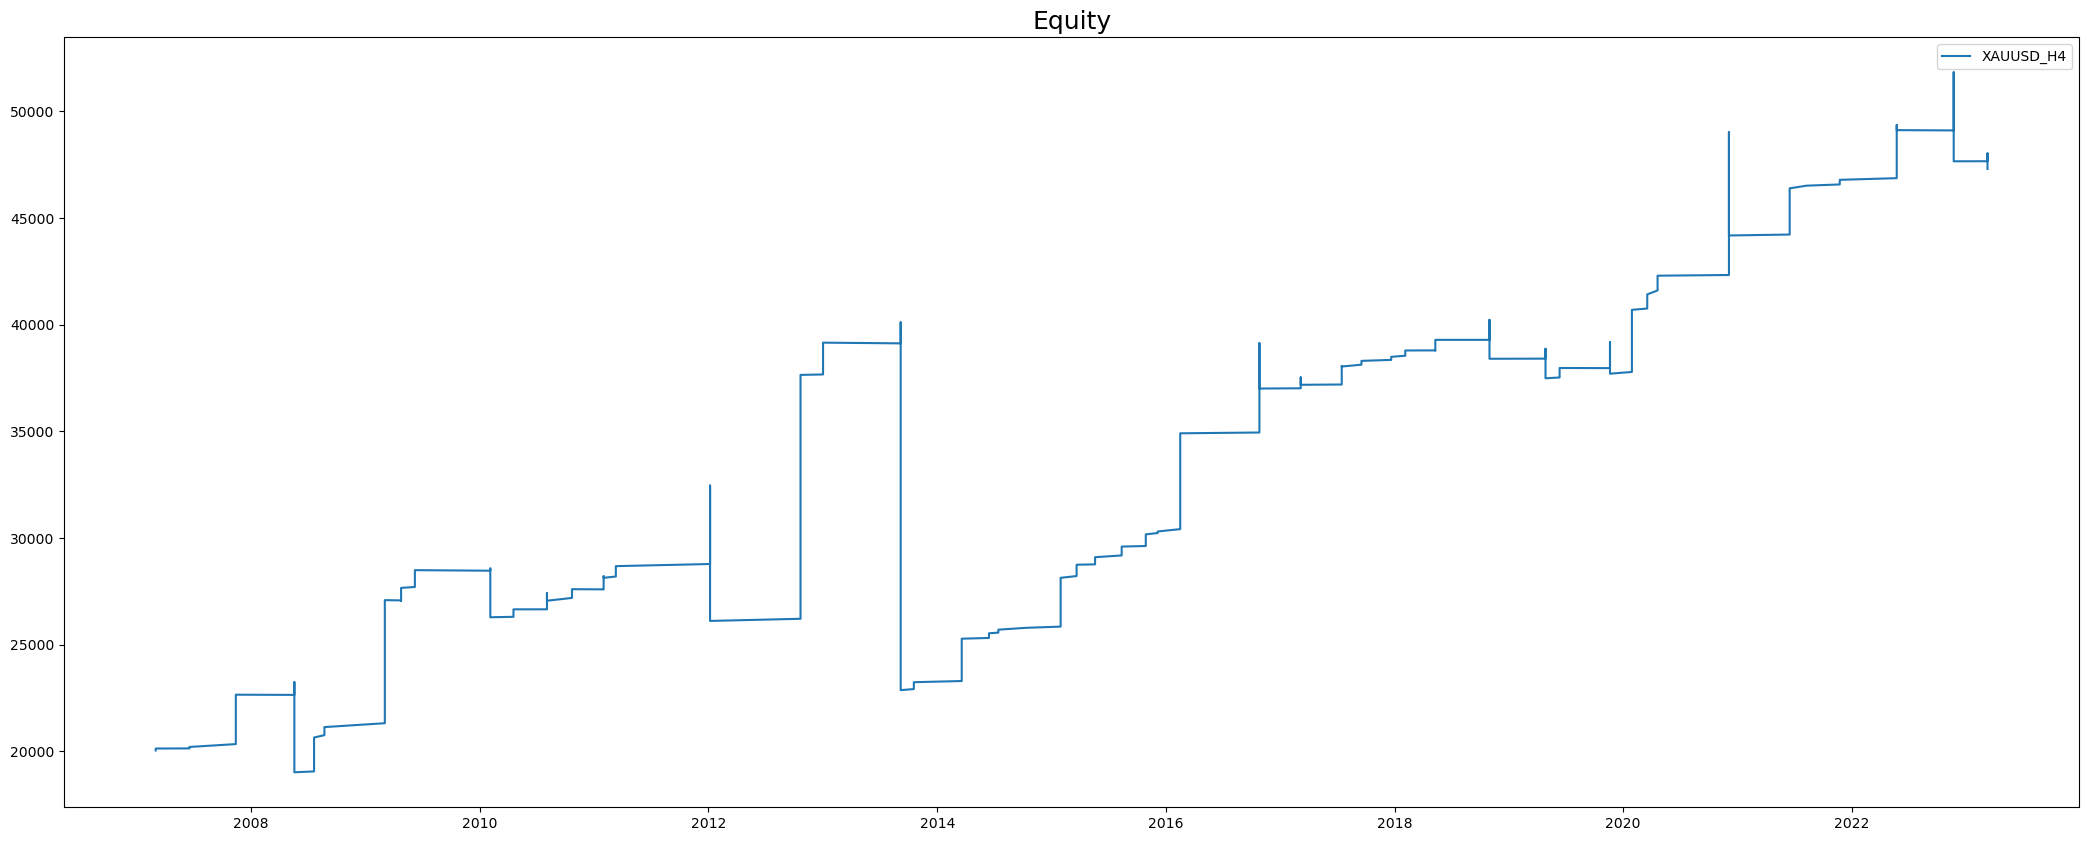

In [52]:
plot_return_trades(result['_trades'], 'XAUUSD_H4' , account_size)